In [1]:
import geopandas as gpd
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
from pyfonts import load_font
from highlight_text import fig_text, ax_text
from drawarrow import ax_arrow, fig_arrow

In [2]:
url = "https://raw.githubusercontent.com/JosephBARBIERDARNAL/data-matplotlib-journey/refs/heads/main/ufo/ufo.csv"
df = pd.read_csv(url)

In [3]:
url = "https://raw.githubusercontent.com/JosephBARBIERDARNAL/data-matplotlib-journey/refs/heads/main/us-counties/us-counties.geojson"
gdf = gpd.read_file(url)

In [4]:
state_dict = {
    "01": "Alabama",
    "02": "Alaska",
    "04": "Arizona",
    "05": "Arkansas",
    "06": "California",
    "08": "Colorado",
    "09": "Connecticut",
    "10": "Delaware",
    "11": "District of Columbia",
    "12": "Florida",
    "13": "Georgia",
    "15": "Hawaii",
    "16": "Idaho",
    "17": "Illinois",
    "18": "Indiana",
    "19": "Iowa",
    "20": "Kansas",
    "21": "Kentucky",
    "22": "Louisiana",
    "23": "Maine",
    "24": "Maryland",
    "25": "Massachusetts",
    "26": "Michigan",
    "27": "Minnesota",
    "28": "Mississippi",
    "29": "Missouri",
    "30": "Montana",
    "31": "Nebraska",
    "32": "Nevada",
    "33": "New Hampshire",
    "34": "New Jersey",
    "35": "New Mexico",
    "36": "New York",
    "37": "North Carolina",
    "38": "North Dakota",
    "39": "Ohio",
    "40": "Oklahoma",
    "41": "Oregon",
    "42": "Pennsylvania",
    "44": "Rhode Island",
    "45": "South Carolina",
    "46": "South Dakota",
    "47": "Tennessee",
    "48": "Texas",
    "49": "Utah",
    "50": "Vermont",
    "51": "Virginia",
    "53": "Washington",
    "54": "West Virginia",
    "55": "Wisconsin",
    "56": "Wyoming",
    "60": "American Samoa",
    "66": "Guam",
    "69": "Northern Mariana Islands",
    "72": "Puerto Rico",
    "78": "U.S. Virgin Islands"
}

gdf["state_name"] = gdf["STATEFP"].map(state_dict)    

In [5]:
df_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
df_joined = gpd.sjoin(df_gdf, gdf, how="inner")
agg_df = df_joined.groupby(["NAME", "STATEFP", "state_name", "COUNTYFP"], as_index=False)["duration"].sum()
result_gdf = gdf.merge(agg_df, on=["NAME", "state_name", "STATEFP", "COUNTYFP"], how="inner").sort_values(["duration"], ascending=False)
result_gdf = result_gdf[["state_name", "STATEFP", "COUNTYFP", "NAME", "geometry", "duration"]]

In [6]:
font = load_font(
   font_url="https://github.com/google/fonts/blob/main/ofl/zendots/ZenDots-Regular.ttf?raw=true"
)
custom_font = load_font(
   font_url="https://github.com/google/fonts/blob/main/ofl/zendots/ZenDots-Regular.ttf?raw=true"
)
custom_font.set_size(7)

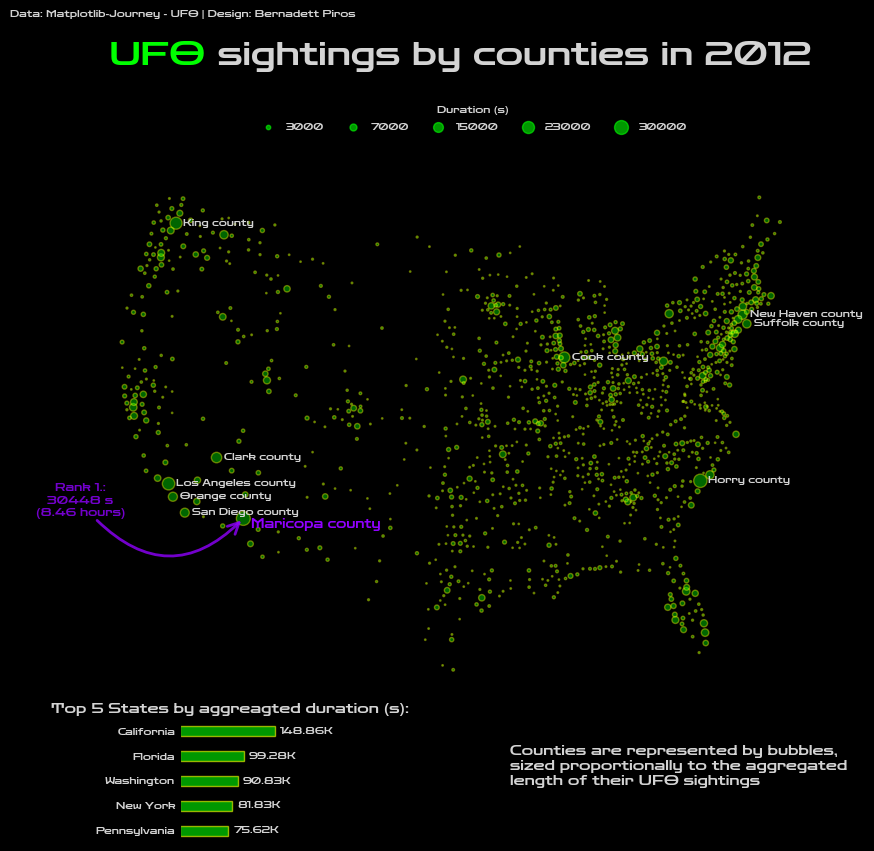

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

result_gdf = result_gdf.to_crs(epsg=2163)
result_gdf["centroid"] = result_gdf.geometry.centroid

min_s = 1
max_s = 100
s = result_gdf["duration"]
s = min_s + (s - s.min()) * (max_s - min_s) / (s.max() - s.min())

x = result_gdf["centroid"].x
y = result_gdf["centroid"].y

scatter = ax.scatter(
    x=x,
    y=y,
    s=s,
    facecolors="lime",
    edgecolors="yellow",
    alpha=0.4,
    label="duration"
)

sightings = agg_df.sort_values(["duration"], ascending=False)[:10]
counties_text = sightings["NAME"].unique()

for county in counties_text:
    county_data = result_gdf.loc[result_gdf["NAME"] == county, "centroid"]
    centroid = county_data.iloc[0]
    x, y = centroid.coords[0]
    ax.text(
        x=x+50000,
        y=y,
        s=f"{county} county",
        fontsize=9 if county=="Maricopa" else 7,
        font=font,
        color="#9000FF" if county=="Maricopa" else "lightgrey",
        weight="bold",
        ha="left",
        va="top" if county=="Maricopa" else "center")

maricopa = result_gdf.loc[result_gdf["NAME"] == "Maricopa", "duration"].iloc[0] 
ax_arrow(tail_position=(-2161367.27, -1208098.655),
         head_position=(-1161367.27, -1208098.655),
         color="#9000FF",
         alpha=0.8,
         width=2,
         fill_head=False,
         radius=0.5) 
ax.text(s=f"Rank 1.:\n{maricopa:.0f} s\n({maricopa/3600:.2f} hours)",
        x=-2261367.27, y=-1108098.655, fontsize=8, font=font, weight="bold", color="#9000FF", alpha=0.8, ha="center", va="center")

ax.set_xlim(-2229800, 3000074)  
ax.set_ylim(-2333356, 1229638)  

legend_sizes = [10, 25, 50, 75, 100]   
legend_labels = ["3000", "7000", "15000", "23000", "30000"]  

legend_handles = [
    plt.scatter([], [], s=size, facecolor="lime", alpha=0.6)
    for size in legend_sizes
]

legend = ax.legend(
    legend_handles,
    legend_labels,
    title="Duration (s)",
    title_fontproperties=custom_font,
    loc="upper center",
    framealpha=0,
    facecolor="black",
    edgecolor="black",
    labelcolor="lightgrey",
    prop=custom_font,    
    labelspacing=0.8,
    ncols=5
)
legend.get_title().set_color("lightgrey")

states = (result_gdf.groupby(["state_name"])
          .sum(["duration"])
          .astype(int)
          .sort_values(["duration"], ascending=False)[:5]
          .reset_index()
          .sort_values(["duration"]))     

child_ax = fig.add_axes([0.22, -0.05, 0.1, 0.15])
bars = child_ax.barh(states["state_name"], states["duration"], height=0.4, color="lime", ec="yellow", alpha=0.6)
for bar, value in zip(bars, states["duration"].values):
    child_ax.text(bar.get_width() + 8000, bar.get_y() + bar.get_height() / 2,
                  '{:.2f}K'.format(value / 1000),
                  ha="left", va="center", font=custom_font, weight="bold", color="lightgrey")

child_ax.tick_params(length=0)
child_ax.set_xticks([])
child_ax.set_facecolor("black")
child_ax.tick_params(
  axis="y",
  labelcolor="lightgrey",
)

for label in child_ax.get_yticklabels():
    label.set_fontproperties(custom_font)  

child_ax.set_title("Top 5 States by aggreagted duration (s):", font=font, color="lightgrey")

fig.text(0.05, 0.98, "Data: Matplotlib-Journey - UFO | Design: Bernadett Piros", color="lightgrey", font=font, fontsize=7)

fig_text(0.5, 0.95, "<UFO> sightings by counties in 2012", fontsize=24, color="lightgrey", font=font, ha="center", 
        highlight_textprops=[
            {"color": "lime", "weight": "bold"}],
         ax=ax
)

fig.text(0.55, 0.02, "Counties are represented by bubbles,\nsized proportionally to the aggregated\nlength of their UFO sightings",
         color="lightgrey", font=font)
            
ax.set_facecolor("black")
fig.set_facecolor("black")

plt.show()

#plt.savefig("bubble_small_multiples_footprint", dpi=300, bbox_inches='tight', pad_inches=0.2)
#plt.savefig("bubble_map_ufo",bbox_inches='tight', pad_inches=0.2)